In [1]:
import spacy
import torch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import re
from transformers import *
from custom.transformer_sentence import TransformerSentence
from custom.chunker import Chunker
from custom.funcs import load_dataset

In [2]:
# LOAD PRETRAINED MODELS (this is the most costly)
# Bert base and large, uncased
#BertBaseModel = BertModel.from_pretrained('bert-base-uncased')
#BertBaseTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#BertLargeModel = BertModel.from_pretrained('bert-large-uncased')
#BertLargeTokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# Scibert uncased
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')
#SciBertBaseVocabModel = BertModel.from_pretrained('scibert-basevocab-uncased')
#SciBertBaseVocabTokenizer = BertTokenizer.from_pretrained('scibert-basevocab-uncased')

Load the test dataset from a .txt file into a list of sentences (list of strings).

In [3]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-5) # similarity func.
chunker = Chunker(layer=-1, 
                  sim_function=cos, 
                  threshold=0.9, 
                  exclude_special_tokens=True, 
                  combinatorics='sequential')

NameError: name 'remove_subsets' is not defined

In [ ]:

def remove_subsets(L):
    filtered = filter(lambda f: not any(set(f) < set(g) for g in L), L)
    return list(filtered)


def indices_to_compact_by_similarity_threshold(sequence_embeddings,
                                               sim_function=cos,
                                               threshold=0.1,
                                               exclude_special_tokens=True,
                                               combinatorics=None):
    # combinatorics= 'sequential', 'all'
    seq_length, embedding_size = sequence_embeddings.size() #make sure the input is proper size!!
    indices = list(range(seq_length))    
    
    # Combinations of indices that are group candidates
    if combinatorics == 'sequential':
        if exclude_special_tokens:
            idx_combinations = [indices[s:e] for s, e in itertools.combinations(range(1, len(indices)), 2)]
        else:
            idx_combinations = [indices[s:e] for s, e in itertools.combinations(range(len(indices)+1), 2)]
            
    elif combinatorics == 'all':
        idx_combinations = []
        for L in range(2, seq_length+1):
            combinations = list(itertools.combinations(indices, r=L))
            idx_combinations.extend(combinations)
    else:
        raise ValueError('You must specify the combinatorics as "sequencial" or "all"!!')
    
    
    all_indices_to_compact = []
    for indices in idx_combinations:
        group_candidate = sequence_embeddings[indices, :]
        group_size = len(indices)
        center = torch.mean(group_candidate, dim=0)
        center = center.repeat(group_size, 1)
        # calculate all embeddings similarities w.r.t. the center of the group
        similarities = sim_function(center, group_candidate)
        worst_sim, _ = torch.min(similarities, dim=0)
        if worst_sim > threshold: all_indices_to_compact.append(indices)
            
    indices_to_compact = remove_subsets(all_indices_to_compact)
    
    return indices_to_compact


def compact_embeddings(original_embeddings, indices_to_compact):
    new_embeddings_list = []
    for indices in indices_to_compact:
        group = original_embeddings[indices, :]
        center = torch.mean(group, dim=0)
        new_embeddings_list.append(center)
        
    new_embeddings = torch.stack(new_embeddings_list, dim=0)
    
    return new_embeddings


def chunks_prediction_from_sentence_objects(sentences_obj, thr=0.9, model_layer=-1):
    transformer_chunks = [] #this is gonna be a list of lists
    for transformer_sentence in sentences_obj:
        sentence_tokens = transformer_sentence.summary['input_tokens']
        full_representation = transformer_sentence.summary['states'][model_layer, :, :]
        indices_to_compact = indices_to_compact_by_similarity_threshold(full_representation,
                                                                        sim_function=cos,
                                                                        threshold=thr,
                                                                        exclude_special_tokens=True,
                                                                        combinatorics='sequential')
        chunks = []
        for chunk_indices in indices_to_compact:
            if len(chunk_indices) > 1:
                tokens = [sentence_tokens[i] for i in chunk_indices]
                # remove leading ## and everything after _ in tokens to match the words
                tokens = [re.sub(r'_(.*)', '', token).replace('##', '') for token in tokens]
                joint_token = '_'.join(tokens)
                chunks.append(joint_token)

        transformer_chunks.append(chunks)
    return transformer_chunks

In [8]:
def recall_between_lists(ground_truth, prediction):
    recall, total = 0, 0
    for i, sentence in enumerate(ground_truth):
        for chunk in sentence:
            total += 1
            if chunk in prediction[i]: recall += 1
    return recall / total

In [7]:
sentences, sentences_obj = load_dataset(txt_path='../datasets/quora_questions.txt',
                                       return_embeddings=False,
                                       MODEL=SciBertModel,
                                       TOKENIZER=SciBertTokenizer)

sentences = [sentence.lower() for sentence in sentences]

100%|██████████| 301/301 [00:34<00:00,  8.83it/s]


In [5]:
s = "What is a bayesian neural network?"
sentence = TransformerSentence(s)
new_embeddings, new_tokens = chunker.compact(sentence)
print(new_tokens)

Sentence Tokenization:  ['[CLS]', 'what', 'is', 'a', 'bayesian', 'neural', 'network', '?', '[SEP]']
['what_is_a_bayesian_neural', 'a_bayesian_neural_network', 'neural_network_?']


In [9]:
#!python -m spacy download en
# Generate the spacy noun chunks as "ground truth"!
nlp = spacy.load("en") # en_core_web_sm

spacy_noun_chunks = [] # this is gonna be a list of lists
for sentence in sentences:
    doc = nlp(sentence)
    chunks = []
    for chunk in doc.noun_chunks:
        joint_token = str(chunk).replace(' ', '_')
        
        chunks.append(joint_token)
    spacy_noun_chunks.append(chunks)

In [10]:
print(spacy_noun_chunks)

[['convolutional_neural_networks', 'tasks', 'image_classification'], ['non-causal_temporal_convolutions', 'the_equivalence'], ['any_techniques', 'rnn/lstm', 'time_series_data'], ['bayesian_inference', 'what', 'a_dirichlet_process', "layman's_terms"], ['an_objective_account', 'statistical_inference', 'frequentist_methods', 'bayesian_methods'], ['bayesian_network', 'deep_learning', 'causation'], ['deep_neural_networks', 'the_minimum_function'], ['facial_recognition_tools'], ['neural_networks', 'lstm', 'time_series_prediction'], ['time_series_dynamic_modelling'], [], ['you', 'the_hmm_algorithm'], ['classification', 'machine_learning', 'i', 'a_k-nn_classifier', 'a_naive_bayes_classifier'], ['computer_vision', 'what', 'the_difference', 'hog', 'feature_descriptor'], ['computer_vision', 'what', 'the_difference', 'local_descriptors', 'global_descriptors'], ['convex_optimization', 'what', 'the_advantage', 'direction_method', 'multipliers', 'admm', 'what', 'the_use_case', 'this_type', 'method', 

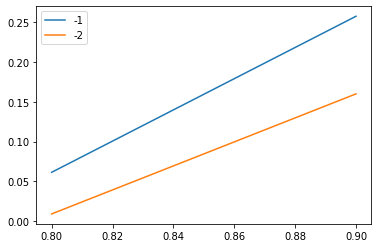

In [12]:
thrs = np.arange(0.80, 1., 0.1)
layer = list(range(-1, -3, -1))
R = []
for L in layer:
    recalls = []
    for thr in thrs:
        tf_chunks = []
        for sentence in sentences_obj:
            _, t = chunker.compact(sentence, threshold=thr, layer=L)
            tf_chunks.append(t)
        r = recall_between_lists(spacy_noun_chunks, tf_chunks)
        recalls.append(r)
    R.append(recalls)


for i, recalls in enumerate(R):
    plt.plot(thrs, recalls, label=layer[i])
plt.legend()

In [33]:
thr=0.9
tf_chunks = chunks_prediction_from_sentence_objects(sentences_obj, thr=thr, model_layer=-4)
for i in range(3):
    print(sentences_obj[i].raw_string)
    print('Spacy chunks: ', spacy_noun_chunks[i])
    print(f'Distance-based chunks, thr={thr}:', tf_chunks[i])

Are convolutional neural networks useful for tasks other than image classification?
Spacy chunks:  ['convolutional_neural_networks', 'tasks', 'image_classification']
Distance-based chunks, thr=0.9: ['convolutional_neural_networks', 'networks_useful', 'useful_for', 'for_tasks', 'other_than', 'image_classification']
Are non-causal temporal convolutions the equivalence of Bi-LSTM?
Spacy chunks:  ['non-causal_temporal_convolutions', 'the_equivalence']
Distance-based chunks, thr=0.9: ['non_-', '-_causal', 'causal_temporal_convolution', 'convolution_s', 's_the', 'the_equivalence', 'equivalence_of', 'of_bi', 'bi_-', 'ls_tm']
Are there any techniques, other than RNN/LSTM, to handle time series data?
Spacy chunks:  ['any_techniques', 'rnn/lstm', 'time_series_data']
Distance-based chunks, thr=0.9: ['there_any', 'any_techniques', 'techniques_,', ',_other', 'other_than', 'rn_n', 'n_/', 'ls_tm', ',_to', 'to_handle', 'handle_time', 'time_series_data']


[-1, -2, -3, -4, -5, -6, -7, -8, -9]

In [27]:
s = "the car broke down while driving in New York."
tf_sentence = TransformerSentence(s, model=BertBaseModel, tokenizer=BertBaseTokenizer)
tf_sentence.write_summary()

Sentence Tokenization:  ['[CLS]', 'the', 'car', 'broke', 'down', 'while', 'driving', 'in', 'new', 'york', '.', '[SEP]']
